# Building NARX models using general estimators

Example created by Wilson Rocha Lacerda Junior

In this example we will create NARX models using different estimator like GradientBoostingRegressor, Bayesian Regression, Automatic Relevance Determination (ARD) Regression and Catboost

In [ ]:
pip install sysidentpy

In [1]:
import matplotlib.pyplot as plt
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.general_estimators import NARX
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [2]:
# simulated dataset
x_train, x_valid, y_train, y_valid = get_siso_data(
    n=10000, colored_noise=False, sigma=0.01, train_percentage=80
)

## Importance of the NARX architecture

To get an idea of the importance of the NARX architecture, lets take a look in the performance of the models without the NARX configuration.

In [3]:
catboost = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=6)

In [4]:
gb = GradientBoostingRegressor(
    loss="quantile",
    alpha=0.90,
    n_estimators=250,
    max_depth=10,
    learning_rate=0.1,
    min_samples_leaf=9,
    min_samples_split=9,
)

In [5]:
def plot_results_tmp(y_valid, yhat):
    _, ax = plt.subplots(figsize=(14, 8))
    ax.plot(y_valid[:200], label="Data", marker="o")
    ax.plot(yhat[:200], label="Prediction", marker="*")
    ax.set_xlabel("$n$", fontsize=18)
    ax.set_ylabel("$y[n]$", fontsize=18)
    ax.grid()
    ax.legend(fontsize=18)
    plt.show()

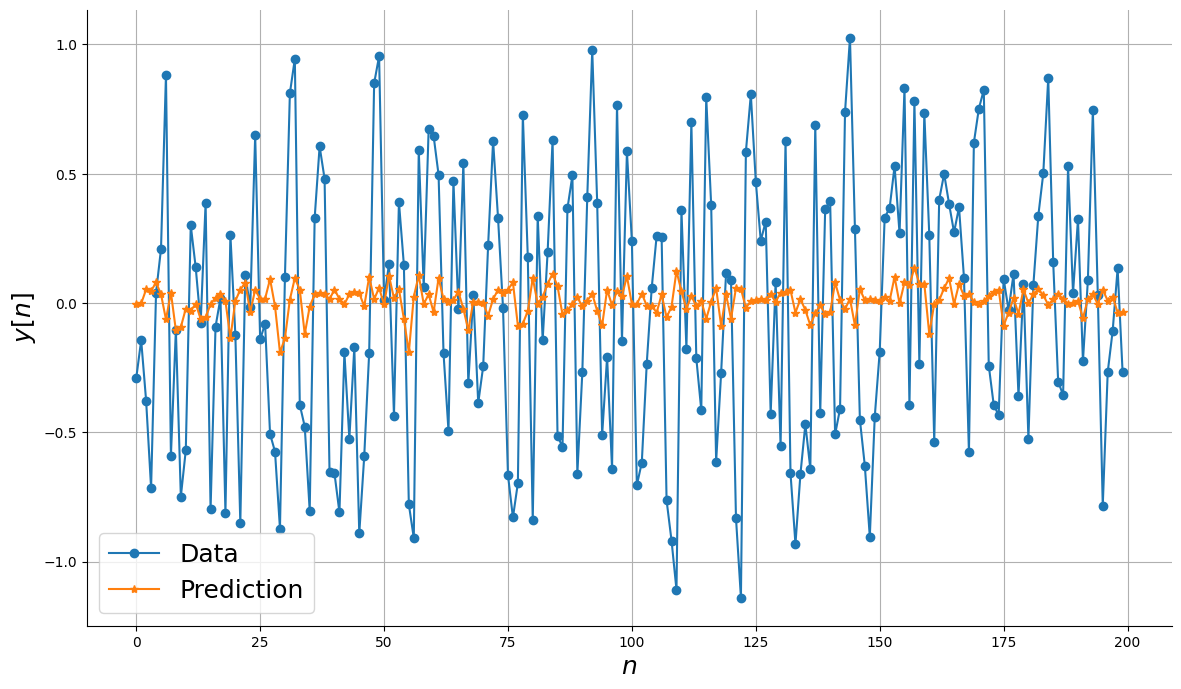

In [6]:
catboost.fit(x_train, y_train, verbose=False)
plot_results_tmp(y_valid, catboost.predict(x_valid))

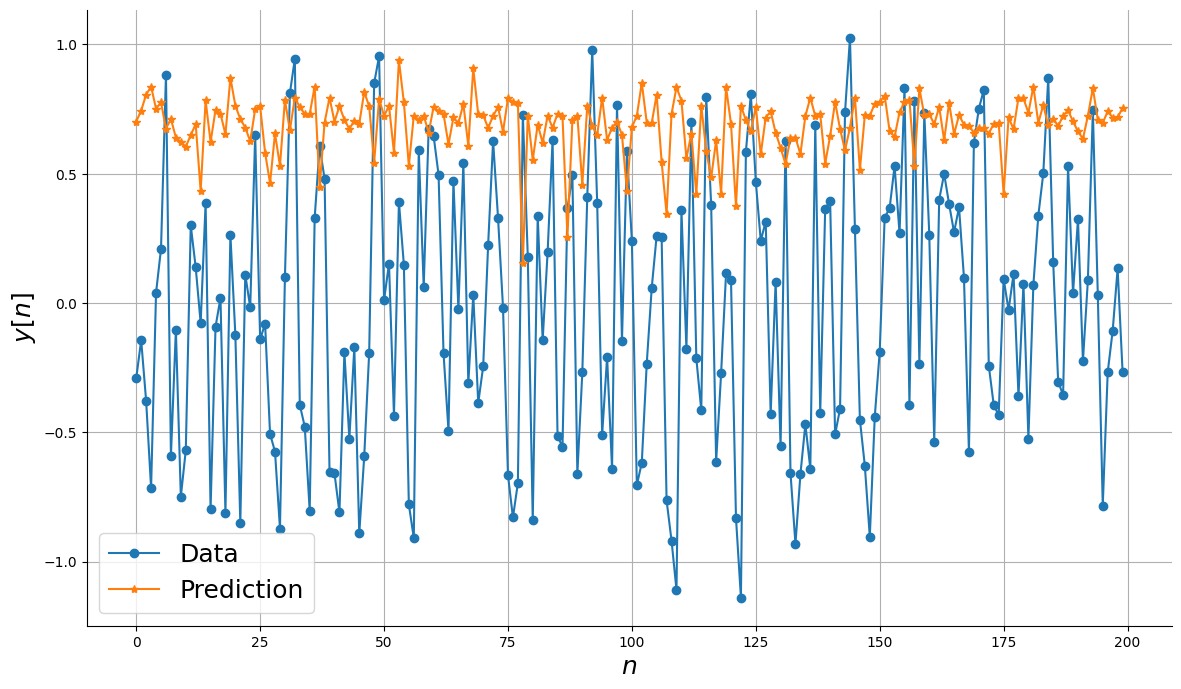

In [7]:
gb.fit(x_train, y_train.ravel())
plot_results_tmp(y_valid, gb.predict(x_valid))

## Introducing the NARX configuration using SysIdentPy

As you can see, you just need to pass the base estimator you want to the NARX class from SysIdentPy do build the NARX model! You can choose the lags of the input and output variables to build the regressor matrix.

 We keep the fit/predict method to make the process straightforward.

### NARX with Catboost

MSE:  0.00022083855101248805


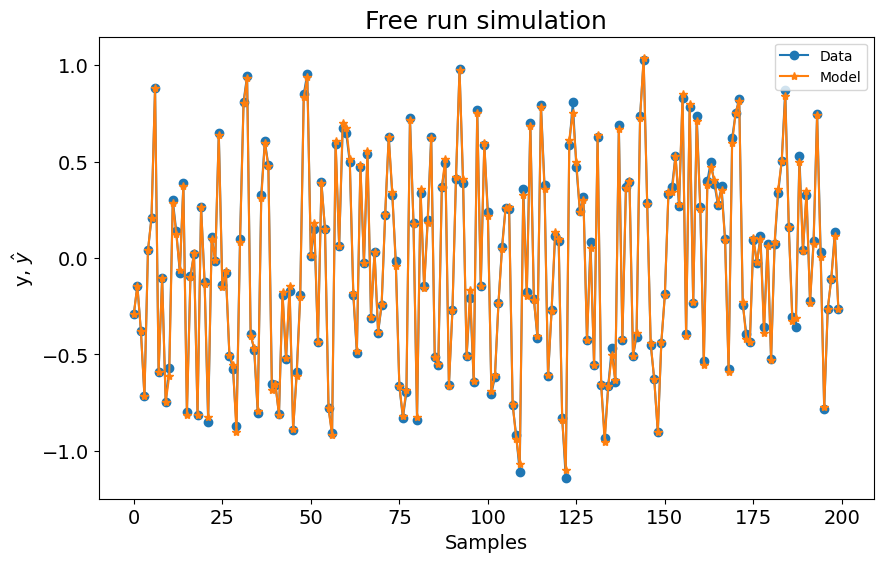

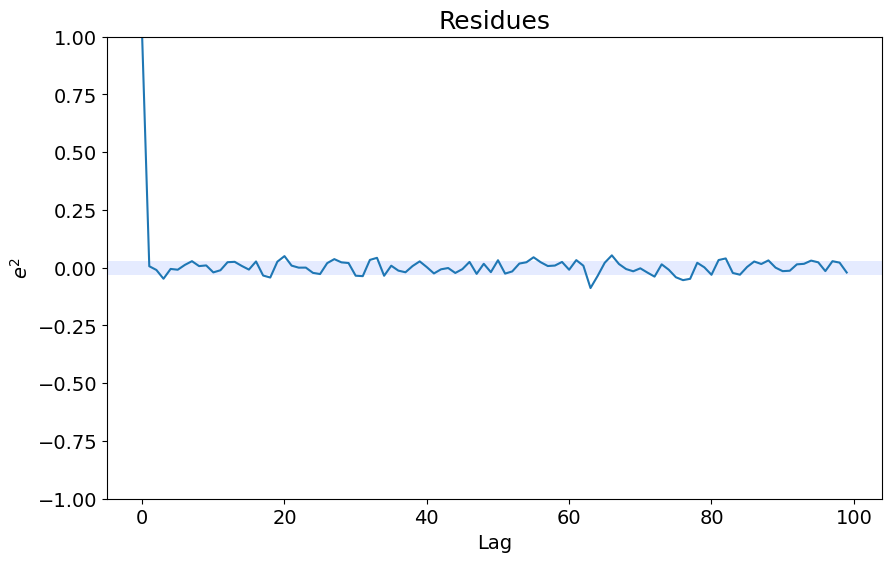

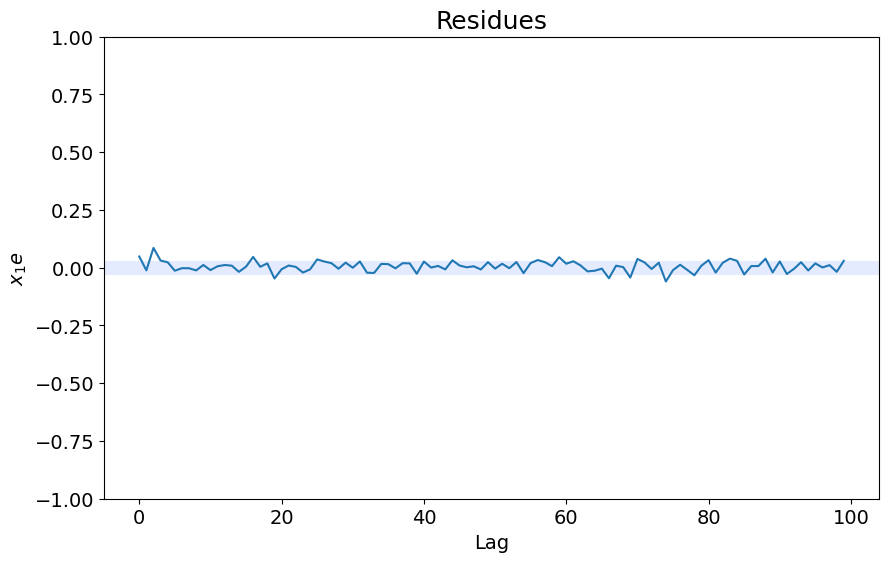

In [8]:
basis_function = Fourier(degree=1)

catboost_narx = NARX(
    base_estimator=CatBoostRegressor(iterations=300, learning_rate=0.1, depth=8),
    xlag=10,
    ylag=10,
    basis_function=basis_function,
    model_type="NARMAX",
    fit_params={"verbose": False},
)

catboost_narx.fit(X=x_train, y=y_train)
yhat = catboost_narx.predict(X=x_valid, y=y_valid, steps_ahead=1)
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=200)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

### NARX with Gradient Boosting

0.0013519489212683146


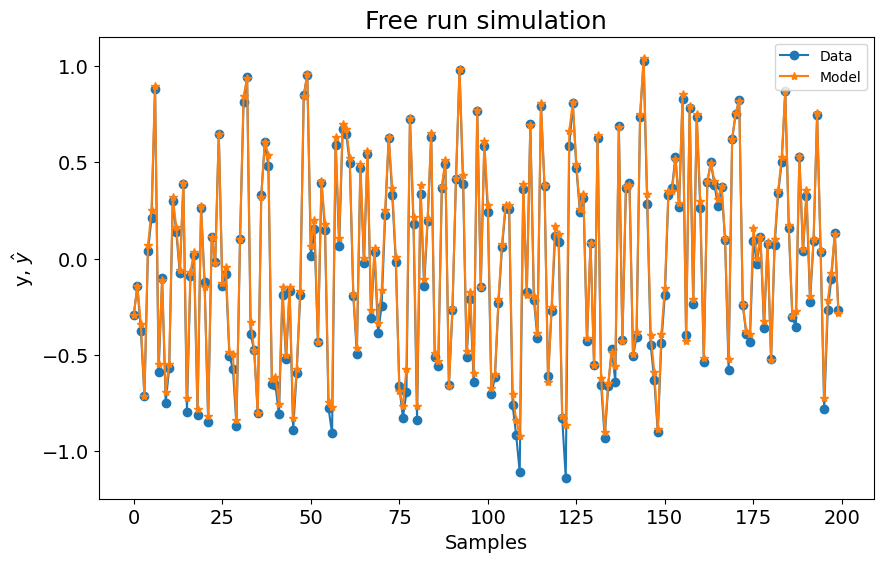

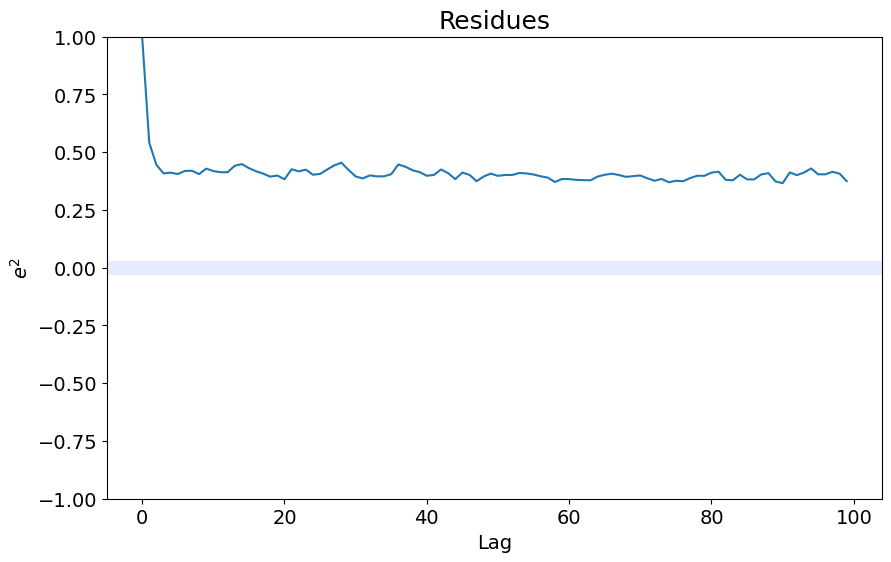

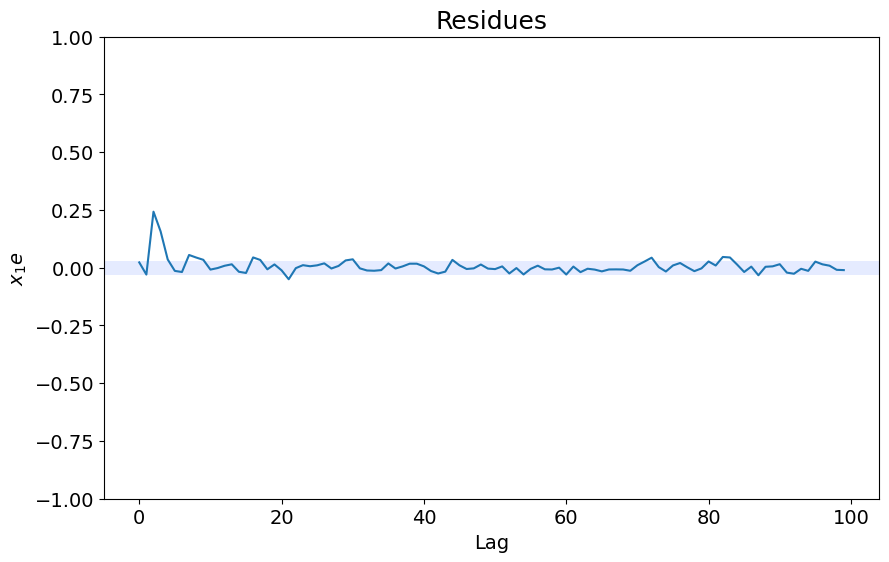

In [9]:
basis_function = Fourier(degree=1)

gb_narx = NARX(
    base_estimator=GradientBoostingRegressor(
        loss="quantile",
        alpha=0.90,
        n_estimators=250,
        max_depth=10,
        learning_rate=0.1,
        min_samples_leaf=9,
        min_samples_split=9,
    ),
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX",
)

gb_narx.fit(X=x_train, y=y_train)
yhat = gb_narx.predict(X=x_valid, y=y_valid)
print(mean_squared_error(y_valid, yhat))

plot_results(y=y_valid, yhat=yhat, n=200)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

### NARX with ARD

0.001087497212624252


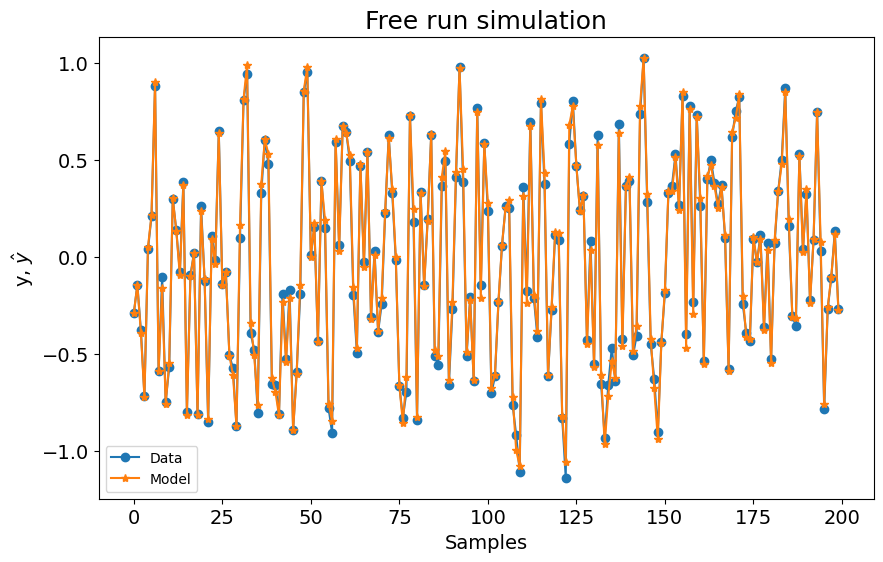

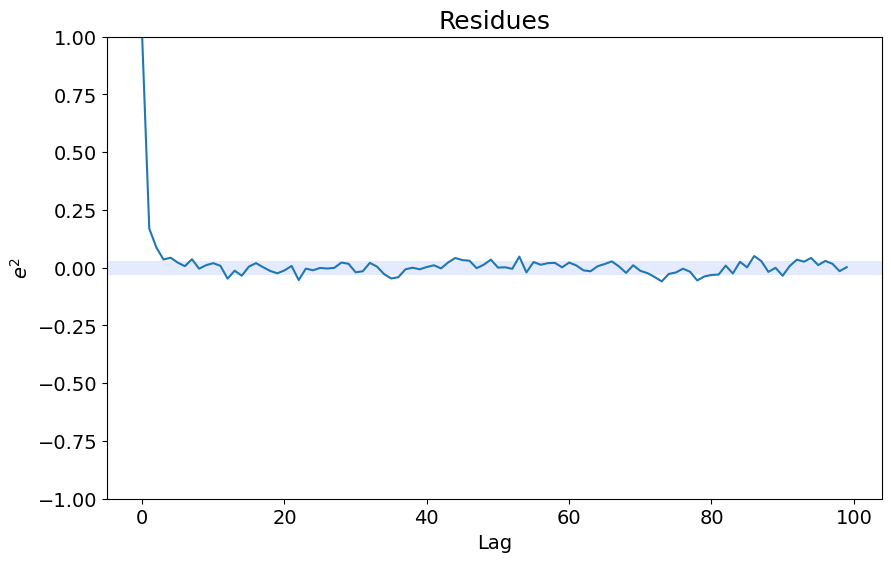

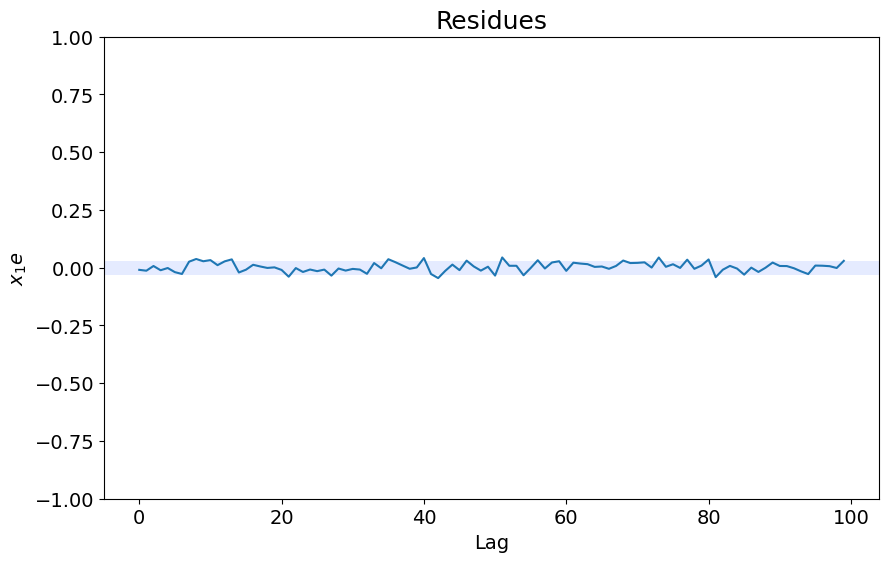

In [10]:
from sysidentpy.general_estimators import NARX

ARD_narx = NARX(
    base_estimator=ARDRegression(),
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX",
)

ARD_narx.fit(X=x_train, y=y_train)
yhat = ARD_narx.predict(X=x_valid, y=y_valid)
print(mean_squared_error(y_valid, yhat))

plot_results(y=y_valid, yhat=yhat, n=200)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

### NARX with Bayesian Ridge

0.0010898810785159086


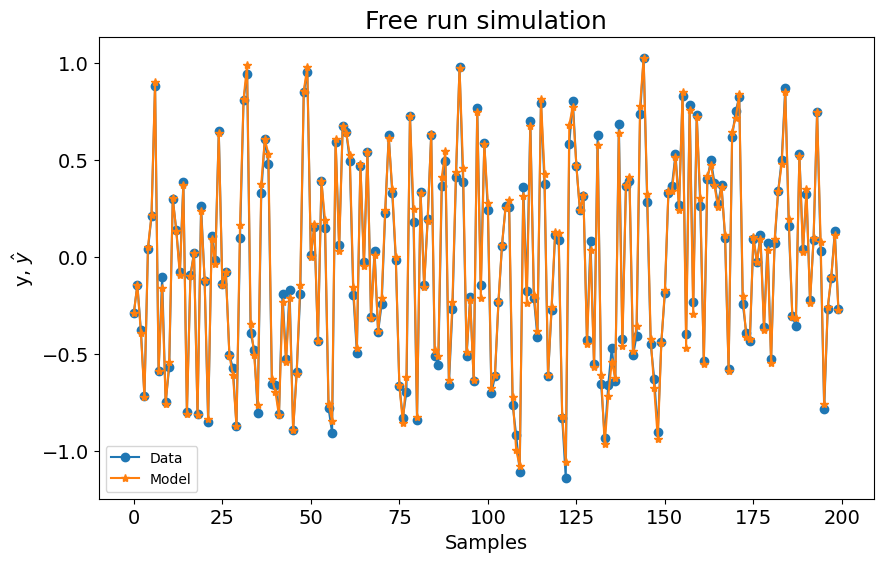

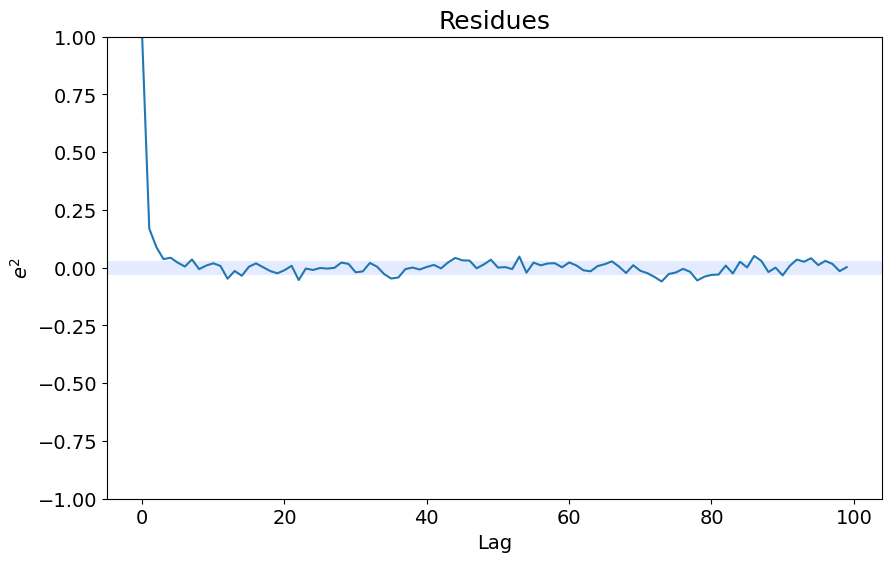

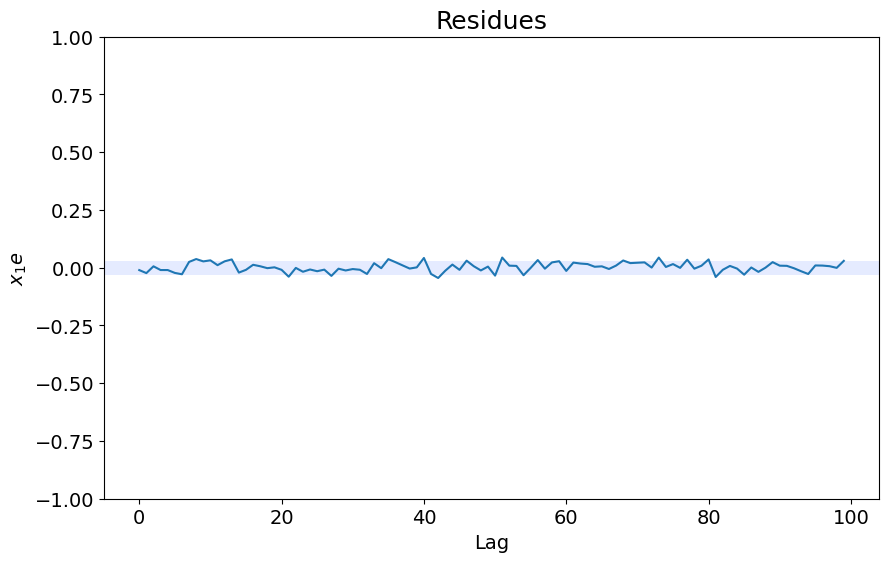

In [11]:
from sysidentpy.general_estimators import NARX

BayesianRidge_narx = NARX(
    base_estimator=BayesianRidge(),
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX",
)

BayesianRidge_narx.fit(X=x_train, y=y_train)
yhat = BayesianRidge_narx.predict(X=x_valid, y=y_valid)
print(mean_squared_error(y_valid, yhat))

plot_results(y=y_valid, yhat=yhat, n=200)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

# Note

Remember you can use n-steps-ahead prediction and NAR and NFIR models now. Check how to use it in their respective examples. 